In [1]:
import numpy as np

from utils import data_utils as du
from utils import plot_utils as pu
from utils import stats_utils as su

# Data Loading

In [14]:
POLICY_YEAR: int = 2019
START_YEAR: int = 2016
END_YEAR: int = 2023

energy_data = du.load_data()
concurrent_df = du.concurrent_buildings(
    input_df=energy_data, start_year=2016, end_year=2023
)
did_df = su.prepare_did_data(concurrent_df)

did_df["Post"] = (did_df["Data Year"] >= POLICY_YEAR).astype(int)
median_rating = did_df["Chicago Energy Rating"].median(skipna=True)
did_df["LowRating"] = (did_df["Chicago Energy Rating"] <= median_rating).astype(int)
median_score = did_df["ENERGY STAR Score"].median(skipna=True)
did_df["LowScore"] = (did_df["ENERGY STAR Score"] <= median_score).astype(int)

# Statistical Analysis & Modeling

### Pre/post comparisons (2016–2018 vs. 2019–2024) of energy efficiency and emissions.

In [3]:
energy_df = concurrent_df.copy()
energy_df["Post_Placard"] = (energy_df["Data Year"] >= POLICY_YEAR).astype(int)
energy_df = energy_df[
    (energy_df["Data Year"] >= START_YEAR) & (energy_df["Data Year"] <= END_YEAR)
]

metrics = [
    "Total GHG Emissions (Metric Tons CO2e)",
    "Site EUI (kBtu/sq ft)",
]

summary = (
    energy_df.groupby("Post_Placard")[metrics]
    .agg(["mean", "median"])
    .T.rename_axis(index=["Metric", "Statistic"])
)

summary.columns = ["Pre (2016–2018)", "Post (2019–2023)"]
summary = summary.reset_index()

summary["Percent Change (%)"] = (
    (summary["Post (2019–2023)"] - summary["Pre (2016–2018)"])
    / summary["Pre (2016–2018)"].replace(0, np.nan)
    * 100
).round(2)

summary

,Metric,Statistic,Pre (2016–2018),Post (2019–2023),Percent Change (%)
0,Total GHG Emissions (Metric Tons CO2e),mean,2530.813227,2057.989326,-18.68
1,Total GHG Emissions (Metric Tons CO2e),median,1102.600000,957.950000,-13.12
2,Site EUI (kBtu/sq ft),mean,91.607152,87.177966,-4.83
3,Site EUI (kBtu/sq ft),median,81.700000,77.900000,-4.65


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Total GHG Emissions (Metric Tons CO2e) Comparison: Before 2019 vs After 2019'}, ylabel='Total GHG Emissions (Metric Tons CO2e)'>)

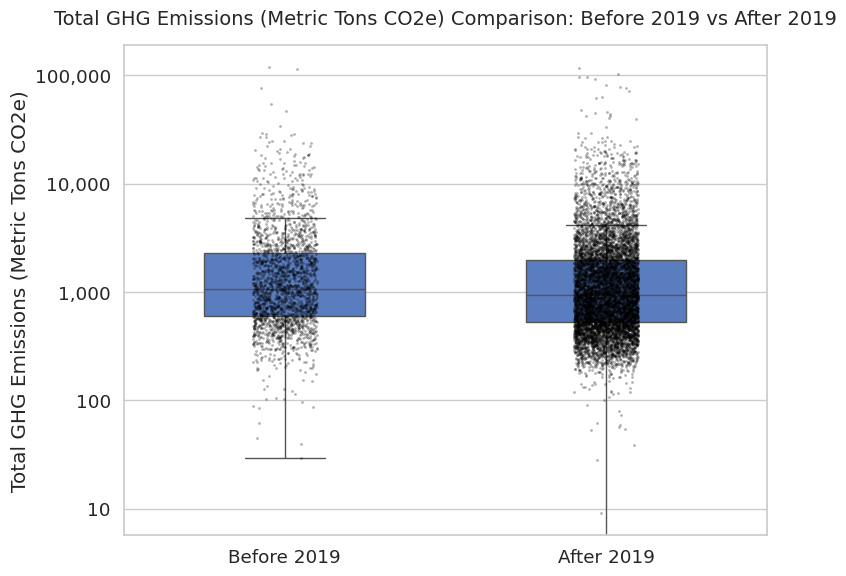

In [4]:
df_pre = did_df[did_df["Data Year"] < POLICY_YEAR]
df_post = did_df[did_df["Data Year"] >= POLICY_YEAR]
pu.compare_variable_distribution(
    df1=df_pre,
    df2=df_post,
    variable="Total GHG Emissions (Metric Tons CO2e)",
    label1="Before 2019",
    label2="After 2019",
    log_scale=True,
)

### DiD

##### Before/After 2019 + Chicago Energy Rating

$$
{GHG}_{it} =
\alpha
+ \beta_1 \text{Post}_{t}
+ \beta_2 \text{LowRating}_{i}
+ \beta_3 (\text{Post}_{t} \times \text{LowRating}_{i})
+ \gamma_1 \ln(\text{FloorArea}_{i})
+ \gamma_2 \text{PropertyType}_{i}
+ \gamma_3 \text{Year}_{t}
+ \gamma_4 \text{YearBuilt}_{t}
+ \varepsilon_{it}
$$

where  

- $ \text{GHG}_{it} $ : total greenhouse-gas emissions (metric tons CO₂e) for building *i* in year *t*  
- $ \text{Post}_{t}=1 $ : if $t \ge 2019$ (post-placard period), 0 otherwise  
- $ \text{LowRating}_{i}=1 $ : if the building’s initial Chicago Energy Rating ≤ 2 (treated group), 0 otherwise  
- $ \text{Post}_{t}\times\text{LowRating}_{i} $ : interaction capturing the differential change for treated buildings after the policy  
- $ \ln(\text{FloorArea}_{i}) $, $ \text{PropertyType}_{i} $, $ \text{Year}_{t} $ : control variables for building size, type, and year fixed effects  
- $ \varepsilon_{it} $ : error term  


In [5]:
model1 = su.run_did_regression(
    did_df, "Total GHG Emissions (Metric Tons CO2e)", include_data_year=True
)
su.summarize_did_results(model1)

[INFO] Showing 8 selected coefficients (policy + energy types).


/project/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 56, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,coef,std_err,p_value,Significance
C(Q('Primary Property Type'))[T.fitness center/health club/gym],6.142560e+02,2.844964e+02,0.0308,**
C(Q('Primary Property Type'))[T.hospital (general medical & surgical)],1.361803e+04,2.257062e+03,0.0000,***
C(Q('Primary Property Type'))[T.laboratory],4.306552e+03,6.652440e+02,0.0000,***
C(Q('Primary Property Type'))[T.other - specialty hospital],1.081841e+03,2.552183e+02,0.0000,***
Post,-6.470946e+14,3.730847e+14,0.0828,*
LowRating,3.930911e+02,6.071850e+01,0.0000,***
Interaction,5.339962e+02,8.728610e+01,0.0000,***
ln_FloorArea,2.484507e+03,7.623650e+01,0.0000,***


In this GHG DID model, the Post-2019 dummy ($\beta_1$), Low-Rating indicator ($\beta_2$), and log floor area are statistically significant.

- After 2019, average GHG emissions per building declined by roughly 1030 metric tons
- Buildings with initially low Chicago Energy Ratings (≤ 2) emitted about 1,121 metric tons more CO2 than originally higher ones
- Interaction term's insignificance indicates that although emissions fell after 2019, low-rated buildings did not experience a significantly different change compared to high-rated ones

$\beta_3$ is relatively small and not significant, impling less effect of placards

In [6]:
model1_log = su.run_did_regression(
    did_df, "Total GHG Emissions (Metric Tons CO2e)", log=True, include_data_year=True
)

su.summarize_did_results(model1_log)

[INFO] Showing 8 selected coefficients (policy + energy types).


/project/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 56, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,coef,std_err,p_value,Significance
C(Q('Primary Property Type'))[T.fitness center/health club/gym],1.841000e-01,1.113000e-01,0.0982,*
C(Q('Primary Property Type'))[T.hospital (general medical & surgical)],7.290000e-01,1.026000e-01,0.0000,***
C(Q('Primary Property Type'))[T.laboratory],9.538000e-01,1.113000e-01,0.0000,***
C(Q('Primary Property Type'))[T.other - specialty hospital],6.322000e-01,1.062000e-01,0.0000,***
Post,3.201171e+10,3.013993e+10,0.2882,
LowRating,3.148000e-01,6.700000e-03,0.0000,***
Interaction,2.129000e-01,7.800000e-03,0.0000,***
ln_FloorArea,9.760000e-01,3.900000e-03,0.0000,***



$$
\text{GHG}_{it} =
\alpha
+ \beta_1 \text{Post}_{t}
+ \beta_2 \text{LowRating}_{i}
+ \beta_3 (\text{Post}_{t} \times \text{LowRating}_{i})
+ \gamma_1 \ln(\text{FloorArea}_{i})
+ \gamma_2 \text{PropertyType}_{i}
+ \gamma_3 \text{YearBuilt}_{t}
+ \varepsilon_{it}
$$

In [7]:
model1_noYear = su.run_did_regression(
    did_df, "Total GHG Emissions (Metric Tons CO2e)", include_data_year=False
)
su.summarize_did_results(model1_noYear)

[INFO] Showing 8 selected coefficients (policy + energy types).


,coef,std_err,p_value,Significance
C(Q('Primary Property Type'))[T.fitness center/health club/gym],584.3271,285.4630,0.0407,**
C(Q('Primary Property Type'))[T.hospital (general medical & surgical)],13617.8101,2255.8784,0.0000,***
C(Q('Primary Property Type'))[T.laboratory],4294.5767,665.8834,0.0000,***
C(Q('Primary Property Type'))[T.other - specialty hospital],1108.0270,255.6709,0.0000,***
Post,-734.3176,76.0053,0.0000,***
LowRating,400.4760,60.9145,0.0000,***
Interaction,535.3130,86.9070,0.0000,***
ln_FloorArea,2478.3645,76.1253,0.0000,***


In [17]:
pu.plot_did_trend(
    did_df,
    year_col="Data Year",
    group_col="LowRating",
    outcome_col="Total GHG Emissions (Metric Tons CO2e)",
    policy_year=2019,
    group_labels={1: "Low Rating (treated)", 0: "High Rating (control)"},
    title="DiD: GHG Emissions by Rating Group",
)

alt.LayerChart(...)

In [9]:
rating_counts = concurrent_df["Chicago Energy Rating"].value_counts().sort_index()
print("\nOverall distribution of ratings:")
print(rating_counts)

rating_by_year = concurrent_df.pivot_table(
    index="Data Year",
    columns="Chicago Energy Rating",
    values="ID",
    aggfunc="count",
    fill_value=0,
).sort_index()

print("\nDistribution of ratings by year:")
display(rating_by_year)


Overall distribution of ratings:
Chicago Energy Rating
0.0    1782
1.0    1861
1.5     696
2.0    1480
2.5    1097
3.0    1509
3.5    1384
4.0    3776
Name: count, dtype: int64

Distribution of ratings by year:


Chicago Energy Rating,0.0,1.0,1.5,2.0,2.5,3.0,3.5,4.0
Data Year,,,,,,,,
2018,80,414,172,311,182,282,195,676
2019,592,263,127,249,172,212,175,453
2020,167,237,69,249,179,253,269,877
2021,332,297,100,194,175,253,247,641
2022,358,310,108,243,191,249,235,549
2023,253,340,120,234,198,260,263,580


##### Before/After 2019 + Energy STAR Score

$$
\text{GHG}_{it}
= \alpha
+ \beta_1 \text{Post}_t
+ \beta_2 \text{LowScore}_i
+ \beta_3 (\text{Post}_t \times \text{LowScore}_i)
+ \gamma_1 \ln(\text{FloorArea}_i)
+ \gamma_2 \text{PropertyType}_i
+ \gamma_3 \text{YearBuilt}_i
+ \varepsilon_{it}
$$


In [19]:
if "LowScore" not in did_df.columns:
    median_score = did_df["ENERGY STAR Score"].median(skipna=True)
    print(f"Median ENERGY STAR Score: {median_score:.1f}")
    did_df["LowScore"] = (did_df["ENERGY STAR Score"] <= median_score).astype(int)

model2 = su.run_did_regression(
    did_df, "Total GHG Emissions (Metric Tons CO2e)", log=False, include_data_year=True
)

su.summarize_did_results(model2)

[INFO] Showing 8 selected coefficients (policy + energy types).


/project/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 56, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,coef,std_err,p_value,Significance
C(Q('Primary Property Type'))[T.fitness center/health club/gym],6.142560e+02,2.844964e+02,0.0308,**
C(Q('Primary Property Type'))[T.hospital (general medical & surgical)],1.361803e+04,2.257062e+03,0.0000,***
C(Q('Primary Property Type'))[T.laboratory],4.306552e+03,6.652440e+02,0.0000,***
C(Q('Primary Property Type'))[T.other - specialty hospital],1.081841e+03,2.552183e+02,0.0000,***
Post,-6.470946e+14,3.730847e+14,0.0828,*
LowRating,3.930911e+02,6.071850e+01,0.0000,***
Interaction,5.339962e+02,8.728610e+01,0.0000,***
ln_FloorArea,2.484507e+03,7.623650e+01,0.0000,***


In [20]:
pu.plot_did_trend(
    did_df,
    year_col="Data Year",
    group_col="LowScore",
    outcome_col="Total GHG Emissions (Metric Tons CO2e)",
    policy_year=2019,
    group_labels={1: "Low ENERGY STAR (treated)", 0: "High ENERGY STAR (control)"},
    title="DiD: GHG Emissions by ENERGY STAR Group",
)

alt.LayerChart(...)

Low-score buildings’ emissions decreased less than high-score buildings after 2019, but the difference is not statistically significant.

##### Site EUI

In [24]:
model3_score = su.run_did_regression(
    did_df, "Site EUI (kBtu/sq ft)", log=True, include_data_year=False
)

su.summarize_did_results(model3_score)

[INFO] Showing 8 selected coefficients (policy + energy types).


,coef,std_err,p_value,Significance
C(Q('Primary Property Type'))[T.fitness center/health club/gym],0.1718,0.1141,0.132,
C(Q('Primary Property Type'))[T.hospital (general medical & surgical)],0.7280,0.1048,0.000,***
C(Q('Primary Property Type'))[T.laboratory],0.9533,0.1140,0.000,***
C(Q('Primary Property Type'))[T.other - specialty hospital],0.6410,0.1092,0.000,***
Post,-0.2630,0.0083,0.000,***
LowRating,0.3166,0.0068,0.000,***
Interaction,0.2129,0.0080,0.000,***
ln_FloorArea,0.9742,0.0040,0.000,***


In [25]:
pu.plot_did_trend(
    did_df,
    year_col="Data Year",
    group_col="LowRating",
    outcome_col="Site EUI (kBtu/sq ft)",
    policy_year=2019,
    group_labels={1: "Low Rating (treated)", 0: "High Rating (control)"},
    title="DiD: Site EUI Emissions by Rating Group",
)
pu.plot_did_trend(
    did_df,
    year_col="Data Year",
    group_col="LowScore",
    outcome_col="Site EUI (kBtu/sq ft)",
    policy_year=2019,
    group_labels={1: "Low ENERGY STAR (treated)", 0: "High ENERGY STAR (control)"},
    title="DiD: Site EUI Emissions by ENERGY STAR Group",
)

alt.LayerChart(...)